## A simple swarm

In [100]:
%load_ext autoreload 
%autoreload 2
import sys
sys.tracebacklimit = 0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [101]:
from core.agent import *
from core.world import * 
from core.map import *
import numpy as np
from core.render import * 

In [102]:
def initialize_swarm(world : World):
    swarm = [Agent() for i in range(1000)]
    for agent in swarm:
        world.add_agent(agent)
    swarm = initialize_positions_randomly(world, swarm)
    

In [103]:
world = World(dims = (100, 100),
              swarm_initialzier= initialize_swarm,
              resource_generator= RandomMapGenerator(),
              energy_model=EnergyModel()
              )
world.reset()

In [104]:
# Test movements by doing random actions
def update():
    world.update()
    # Comms protocol (receiving)
    for agent in world.agents: 
        received_messages = agent.get_messages()
        for msg in received_messages: 
            agent.add_relation(msg.sender, msg.message)
        agent.clear_messages()

    for agent in world.agents:
        action_choice = np.random.randint(0, 4)
        choice = np.random.randint(1, 5)

        match (action_choice): 
            case 1: agent.move(choice)
            case 2: agent.pick_up(choice)
            case 3: agent.put_down(choice)
    
    # Comms protocol (sending )
    for agent in world.agents:
        neighbors = agent.agents_in_range 

        # Send agents
        if len (neighbors) > 0:
            choice = np.random.choice(neighbors)
            tgt_agent = world.get_agent(choice)
            agent.talk_to(tgt_agent)

update()

In [105]:
render_world(world, (800, 800), update_fn=update, delay_s=0)

# Data Visualization

## Social Network Formed

In [113]:
import networkx as nx 
import matplotlib.pyplot as plt

In [107]:
network = nx.graph.Graph()

for agent in world.agents:
    for neighbor in agent._current_state.relations:
        network.add_edge(agent.id, neighbor, weight = agent._current_state.relations[neighbor])

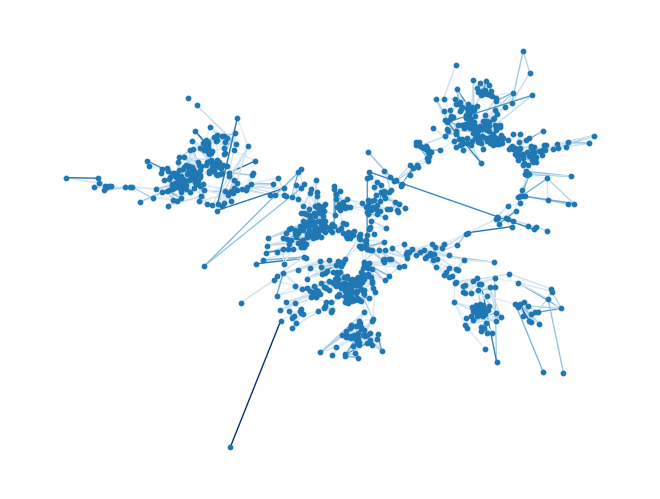

In [114]:
edges,weights = zip(*nx.get_edge_attributes(network ,'weight').items())
nx.draw_kamada_kawai(network, node_size = 10, edge_color = weights, edge_cmap = plt.cm.Spectral)

## Verify certain things about the simulation

In [99]:
swarm = world.agents

In [86]:
# Validate the observation space provided is sensible
obs = swarm[123].local_observation

print(obs.nearby_agents, obs.nearby_agents.shape)
print(obs.resource_types, obs.resource_types.shape)

[[  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 757]
 [254   0   0   0   0   0   0]
 [  0   0   0 124   0   0   0]
 [  0   0   0   0   0   0   0]
 [756 824   0 607   0 514 283]
 [  0   0 886   0   0   0   0]] (7, 7)
[[5 5 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]] (7, 7)


In [87]:
# Validate that all swarm agents landed in different positions
positions = set()
for agent in swarm:
    pos = agent.current_position
    positions.add((pos[0], pos[1]))

print(len(positions), len(world.agents))

1000 1000


In [88]:
# Check for resources
rsrc_qty = world._resource_map._resource_quantity_map
qtys = []

for i in range(rsrc_qty.shape[0]):
    for j in range(rsrc_qty.shape[1]):
        if rsrc_qty[i, j] > 0:
            qtys.append(rsrc_qty[i, j])

print(qtys)

[2, 6, 3, 3, 3, 4, 2, 3, 9, 6, 5, 5, 7, 3, 3, 5, 8, 1, 4, 6, 5, 2, 6, 1, 4, 6, 8, 5, 1, 8, 6, 4, 2, 4, 5, 5, 4, 4, 5, 4, 5, 3, 1, 5, 5, 6, 1, 4, 3, 3, 4, 4, 6, 1, 1, 2, 8, 1, 4, 6, 4, 5, 7, 1, 4, 1, 5, 6, 3, 8, 2, 5, 4, 5, 2, 4, 1, 2, 1, 2, 8, 1, 2, 8, 2, 2, 7, 2, 3, 7, 7, 4, 4, 5, 6, 5, 4, 6, 1, 5, 2, 3, 4, 1, 6, 1, 2, 3, 5, 3, 6, 2, 3, 2, 3, 4, 2, 3, 3, 4, 4, 1, 5, 4, 3, 5, 5, 5, 1, 1, 1, 7, 3, 3, 5, 3, 1, 2, 4, 5, 1, 1, 3, 3, 2, 3, 6, 3, 1, 4, 5, 5, 4, 6, 7, 6, 8, 6, 6, 2, 5, 6, 5, 3, 4, 3, 3, 1, 2, 1, 2, 3, 4, 3, 3, 2, 9, 4, 3, 5, 3, 2, 2, 1, 7, 6, 4, 3, 1, 4, 3, 2, 6, 3, 3, 4, 8, 1, 7, 3, 1, 6, 2, 5, 2, 5, 3, 5, 9, 5, 3, 5, 10, 1, 4, 1, 6, 8, 5, 7, 4, 5, 5, 7, 6, 6, 5, 4, 6, 2, 5, 6, 4, 5, 6, 4, 4, 3, 7, 5, 3, 3, 9, 7, 2, 4, 2, 3, 4, 4, 1, 5, 4, 5, 3, 4, 5, 2, 4, 1, 5, 6, 2, 6, 4, 3, 5, 6, 7, 5, 5, 4, 6, 2, 3, 6, 1, 6, 4, 1, 1, 1, 2, 4, 8, 6, 5, 3, 1, 7, 5, 6, 3, 4, 7, 4, 7, 3, 2, 2, 7, 3, 7, 4, 8, 6, 7, 3, 6, 1, 3, 3, 5, 4, 2, 5, 5, 4, 6, 4, 4, 3, 3, 7, 2, 2, 6, 4, 9, 7, 6, 2, 6,

In [89]:
# Check for agent state
state = swarm[0]._current_state.inventory
print(state)


[]


# Perftest

In [90]:
import cProfile
def stress_test():
    np.random.seed(42)
    world.reset()
    for _ in range(0, 1000):
        update()

In [91]:

cProfile.run('stress_test()', sort = 'time')

         58841452 function calls in 25.670 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  2000150    2.475    0.000    2.475    0.000 {method 'randint' of 'numpy.random.mtrand.RandomState' objects}
     1000    1.748    0.002   25.840    0.026 254406432.py:2(update)
  1000000    1.616    0.000    2.093    0.000 world.py:142(_get_nearby_resources)
   609715    1.551    0.000    3.786    0.000 {method 'choice' of 'numpy.random.mtrand.RandomState' objects}
  1000000    1.491    0.000    1.982    0.000 world.py:130(_get_nearby_agents)
     1000    1.345    0.001    2.059    0.002 world.py:88(_update_movement)
  1000000    1.258    0.000    3.009    0.000 observation.py:22(neighbors)
     1000    1.170    0.001   12.023    0.012 world.py:51(update)
  1000000    1.042    0.000    1.042    0.000 observation.py:28(<listcomp>)
   807943    0.859    0.000    0.859    0.000 {method 'reduce' of 'numpy.ufunc' objects}
   807943    0.

In [92]:
cProfile.run('world.update()', sort = 'time')

         26014 function calls in 0.009 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     1000    0.002    0.000    0.002    0.000 world.py:142(_get_nearby_resources)
     1000    0.002    0.000    0.002    0.000 world.py:130(_get_nearby_agents)
        1    0.001    0.001    0.002    0.002 world.py:88(_update_movement)
        1    0.001    0.001    0.009    0.009 world.py:51(update)
     5000    0.001    0.000    0.001    0.000 {built-in method builtins.max}
     1000    0.000    0.000    0.001    0.000 models.py:11(forward)
        1    0.000    0.000    0.001    0.001 world.py:188(get_presence_mask)
     4000    0.000    0.000    0.000    0.000 {built-in method builtins.min}
     5000    0.000    0.000    0.000    0.000 agent.py:282(current_position_const)
     1000    0.000    0.000    0.000    0.000 agent.py:259(set_position)
     1000    0.000    0.000    0.000    0.000 agent.py:223(set_observation)
     1000    0.